# 프로젝트 소개

### 개인 프로젝트(2주간)
주어진 데이터셋 중 원하는 데이터셋을 사용해 원하는 사전 훈련 모델(CNN)을 훈련시키고, 연구보고서를 작성해 보세요.

- (필수) Test Accuracy, Test Loss 출력 값과 성능 시각화(그래프)를 포함한 연구 및 분석 과정에 대한 내용이 있어야합니다.개인 프로젝트 DB 관련 추가 미션
- (필수) 학습 기록을 RDB나 NoSQL에 저장해보세요. (에포크 번호, 학습 시작 시각, 학습 종료 시각, 학습 결과 손실 함수값과 정확도 등)


https://www.notion.so/adapterz/17c394a48061814a908cfed09c25d3d6#1b9394a48061809882ecdcd41f0dc5a5

https://www.kaggle.com/datasets/imsparsh/flowers-dataset/data

# Import

In [ ]:
import os
from google.colab import files
from collections import Counter
import zipfile
from PIL import Image
import sqlite3
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import transforms, datasets, models

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

#데이터 다운로드

In [ ]:
files.upload()

# Kaggle API 인증 설정
os.makedirs('/root/.kaggle', exist_ok=True)
os.rename('kaggle1.json', '/root/.kaggle/kaggle.json')

# API 사용 권한 설정
os.chmod('/root/.kaggle/kaggle.json', 0o600)

!kaggle datasets download -d imsparsh/flowers-dataset

# 다운로드한 파일 압축 풀기
with zipfile.ZipFile('/content/flowers-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/flowers_dataset')

Saving kaggle1.json to kaggle1.json
Dataset URL: https://www.kaggle.com/datasets/imsparsh/flowers-dataset
License(s): CC0-1.0
flowers-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !mkdir -p ~/.kaggle
# !cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/

# !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# !kaggle datasets download -d imsparsh/flowers-datasetimport zipfile

In [ ]:
import zipfile

# 다운로드한 파일 압축 풀기
with zipfile.ZipFile('/content/flowers-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/flowers_dataset')

# 데이터 구조 및 특성 확인

데이터셋 구조:
폴더: /content/flowers_dataset/train, 포함된 폴더: ['daisy', 'sunflower', 'tulip', 'rose', 'dandelion'], 포함된 파일 수: 0
폴더: /content/flowers_dataset/train/daisy, 포함된 폴더: [], 포함된 파일 수: 501
폴더: /content/flowers_dataset/train/sunflower, 포함된 폴더: [], 포함된 파일 수: 495
폴더: /content/flowers_dataset/train/tulip, 포함된 폴더: [], 포함된 파일 수: 607
폴더: /content/flowers_dataset/train/rose, 포함된 폴더: [], 포함된 파일 수: 497
폴더: /content/flowers_dataset/train/dandelion, 포함된 폴더: [], 포함된 파일 수: 646

클래스 이름: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
총 클래스 개수: 5

클래스별 이미지 개수:
- daisy: 501개
- dandelion: 646개
- rose: 497개
- sunflower: 495개
- tulip: 607개

샘플 이미지 크기: [<built-in method size of Tensor object at 0x7ea8cc048dd0>, <built-in method size of Tensor object at 0x7ea8cc048e30>, <built-in method size of Tensor object at 0x7ea8cc048d70>, <built-in method size of Tensor object at 0x7ea8cc048ef0>, <built-in method size of Tensor object at 0x7ea8cc048f50>]


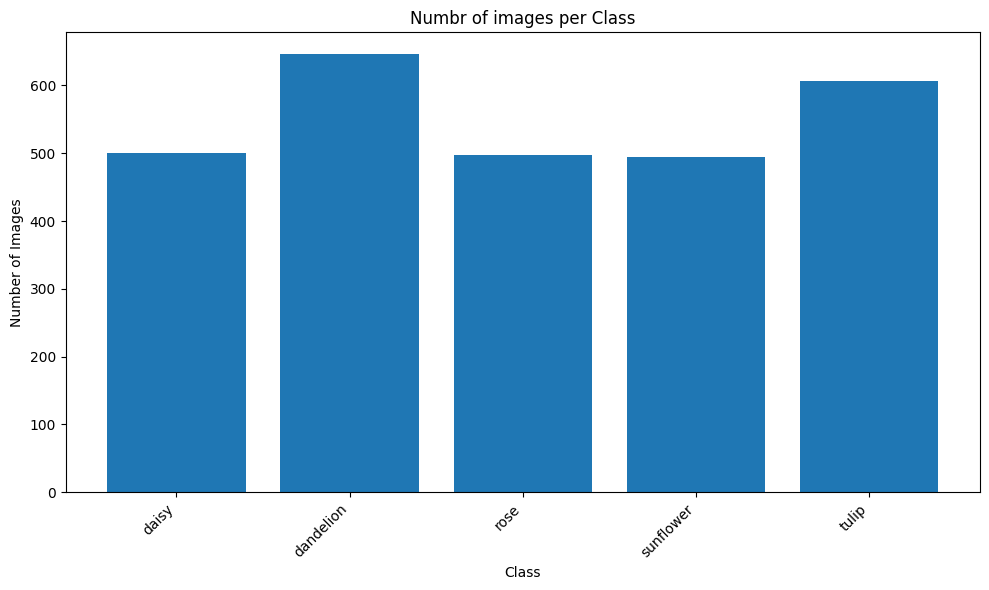

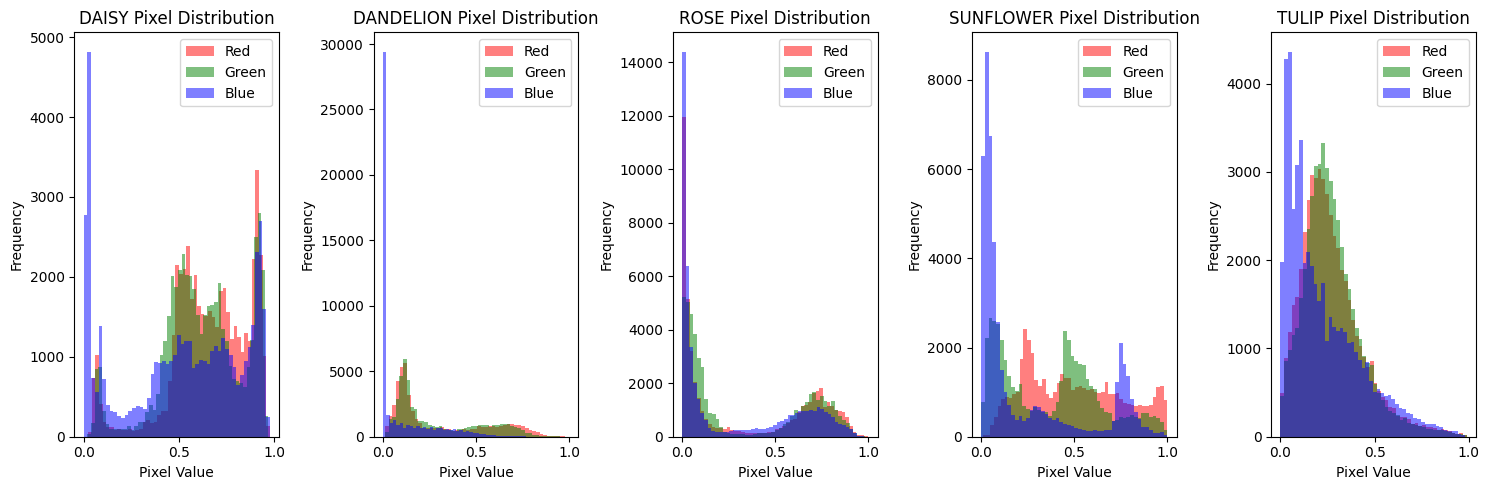

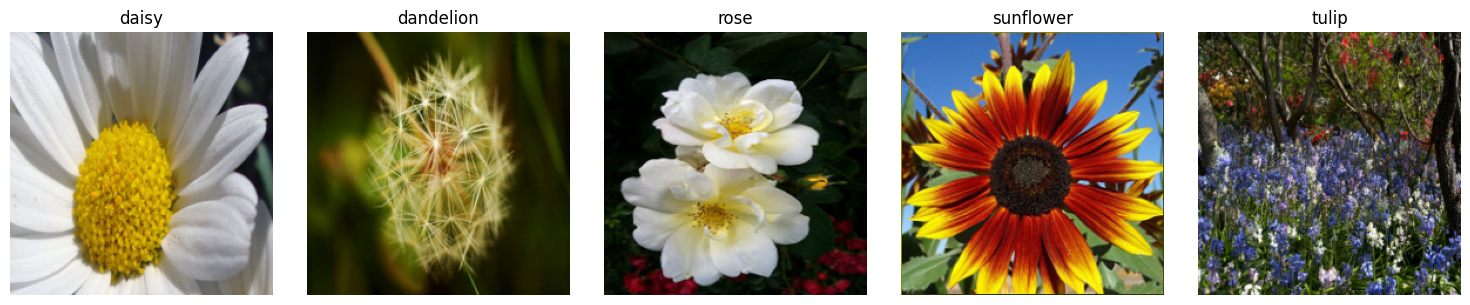

In [ ]:
import os
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# 데이터셋 경로 설정
data_dir = '/content/flowers_dataset/train'

# 사용할 전처리 방식 정의 (시각화를 위해 Normalize는 제외)
test_transform_visualize = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# 1. 데이터셋 구조 파악
print("데이터셋 구조:")
for root, dirs, files in os.walk(data_dir):
    print(f"폴더: {root}, 포함된 폴더: {dirs}, 포함된 파일 수: {len(files)}")

# 2. 클래스 정보 확인
dataset = ImageFolder(root=data_dir, transform=test_transform_visualize)
class_names = dataset.classes
print("\n클래스 이름:", class_names)
num_classes = len(class_names)
print("총 클래스 개수:", num_classes)

# 3. 클래스별 이미지 개수 확인
class_counts = Counter(dataset.targets)
print("\n클래스별 이미지 개수:")
for class_name, count in zip(class_names, class_counts.values()):
    print(f"- {class_name}: {count}개")

# 4. 이미지 크기 확인 (처음 다섯 개 이미지의 크기 확인)
image_sizes = []
for i in range(min(5, len(dataset))):
    img, _ = dataset[i]
    image_sizes.append(img.size)
print("\n샘플 이미지 크기:", image_sizes)

# 5. 클래스별 이미지 수 분포 시각화
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_counts.values())
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Numbr of images per Class")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#모든 클래스 이름 가져오기
first_five_classes = class_names[:]

# 각 클래스별로 하나의 샘플 이미지를 저장할 딕셔너리
samples = {}

# 데이터셋을 순회하면서 처음 5개 클래스의 샘플 이미지를 찾기
for img, label in dataset:
    class_name = class_names[label]
    if class_name in first_five_classes and class_name not in samples:
        samples[class_name] = img
        if len(samples) == 5:
            break

# 6. 각 클래스에 대한 이미지 픽셀 값 분포 시각화
plt.figure(figsize=(15, 5))
for i, class_name in enumerate(first_five_classes):
    img_tensor = samples[class_name]
    r_channel = img_tensor[0, :, :].numpy().flatten()
    g_channel = img_tensor[1, :, :].numpy().flatten()
    b_channel = img_tensor[2, :, :].numpy().flatten()

    plt.subplot(1, 5, i + 1)
    plt.hist(r_channel, bins=50, color='red', alpha=0.5, label='Red')
    plt.hist(g_channel, bins=50, color='green', alpha=0.5, label='Green')
    plt.hist(b_channel, bins=50, color='blue', alpha=0.5, label='Blue')
    plt.title(f"{class_name.upper()} Pixel Distribution")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.legend()
plt.tight_layout()
plt.show()

# 7. 각 클래스에 대한 샘플 이미지 시각화
plt.figure(figsize=(15, 3))
for i, class_name in enumerate(first_five_classes):
    if class_name in samples:
        img_tensor = samples[class_name]
        # (C, H, W) -> (H, W, C) 변환
        img_np = img_tensor.permute(1, 2, 0).numpy()
        plt.subplot(1, 5, i + 1)
        plt.imshow(img_np)
        plt.title(class_name)
        plt.axis('off')
    else:
        # 해당 클래스의 이미지를 찾지 못한 경우 (예외 처리)
        plt.subplot(1, 5, i + 1)
        plt.text(0.5, 0.5, f"No Image\nFound for\n{class_name}", ha='center', va='center')
        plt.axis('off')
plt.tight_layout()
plt.show()

# 데이터베이스 설정

In [ ]:
# SQLite 데이터베이스 연결 및 테이블 생성
conn = sqlite3.connect('training_logs.db')
cursor = conn.cursor()
cursor.execute('''
    CREATE TABLE IF NOT EXISTS training_log (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        session_id INTEGER,
        epoch INTEGER,
        start_time TEXT,
        end_time TEXT,
        train_loss REAL,
        train_accuracy REAL,
        test_loss REAL,
        test_accuracy REAL
    )
''')
conn.commit()

# 모델 평가 함수화

In [ ]:
# 조기 종료 함수
def early_stopping(val_loss_history, patience=5, min_delta=0.01):
    if len(val_loss_history) <= patience:
        return False

    # 최근 patience 수만큼의 검증 손실이 개선되지 않았는지 확인
    recent_losses = val_loss_history[-patience:]
    best_loss = min(val_loss_history[:-patience])

    if all(loss >= best_loss - min_delta for loss in recent_losses):
        return True
    return False

In [ ]:
# 데이터 훈련 및 평가 함수
def train_and_evaluate(model,
                       train_dataloader,
                       test_dataloader,
                       criterion,
                       optimizer,
                       session_id=1,
                       num_epochs=30):
    """
    모델을 훈련하고 평가하는 함수.
    session_id를 추가로 받아서 DB에 함께 기록함.

    Args:
        model (nn.Module): 훈련할 PyTorch 모델.
        train_dataloader (DataLoader): 학습 데이터 로더.
        test_dataloader (DataLoader): 테스트 데이터 로더.
        criterion (nn.Module): 손실 함수.
        optimizer (optim.Optimizer): 최적화 알고리즘.
        session_id (int): 모델/세션 구분용 ID.
        num_epochs (int): 총 학습 에폭 수.

    Returns:
        tuple: (train_loss_history, train_acc_history,
                test_loss_history, test_acc_history, best_test_acc)
    """
    train_loss_history = []
    train_acc_history = []
    test_loss_history = []
    test_acc_history = []
    best_model_state = None
    best_test_acc = 0

    for epoch in range(num_epochs):
        epoch_start_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

        # ------ Training ------
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / len(train_dataloader)
        epoch_train_acc = 100.0 * correct / total
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        # ------ Validation/Test ------
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_dataloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_test_loss = running_loss / len(test_dataloader)
        epoch_test_acc = 100.0 * correct / total
        test_loss_history.append(epoch_test_loss)
        test_acc_history.append(epoch_test_acc)

        epoch_end_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

        # ------ DB INSERT ------
        cursor.execute('''
            INSERT INTO training_log (
                session_id, epoch, start_time, end_time,
                train_loss, train_accuracy, test_loss, test_accuracy
            )
            VALUES (?, ?, ?, ?, ?, ?, ?, ?)
        ''', (session_id, epoch+1, epoch_start_time, epoch_end_time,
              epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc))
        conn.commit()

        # ------ Best Model Update ------
        if epoch_test_acc > best_test_acc:
            best_test_acc = epoch_test_acc
            best_model_state = model.state_dict().copy()

        print(f"[Session {session_id}] Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_acc:.2f}%, "
              f"Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {epoch_test_acc:.2f}%")

        if early_stopping(test_loss_history):
            print(f"Early stopping at epoch {epoch+1}")
            break

    # ------ Load Best Model ------
    if best_model_state:
        model.load_state_dict(best_model_state)
        print(f"[Session {session_id}] Best model restored with test accuracy: {best_test_acc:.2f}%")

    print(f"[Session {session_id}] Training complete.")
    return train_loss_history, train_acc_history, test_loss_history, test_acc_history, best_test_acc


In [ ]:
# 학습 및 테스트 과정의 손실과 정확도 그래프를 그리는 함수
def plot_training_history(train_loss_history, train_acc_history, test_loss_history, test_acc_history, title='Training History'):
    """
    학습 과정의 손실과 정확도 그래프를 그리는 함수.

    Args:
        train_loss_history (list): 학습 손실 기록.
        test_loss_history (list): 테스트 손실 기록.
        train_acc_history (list): 학습 정확도 기록.
        test_acc_history (list): 테스트 정확도 기록.
        title (str): 그래프 제목.
    """
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label='Train Loss')
    plt.plot(range(1, len(test_loss_history) + 1), test_loss_history, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Loss during {title}')

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_acc_history) + 1), train_acc_history, label='Train Accuracy')
    plt.plot(range(1, len(test_acc_history) + 1), test_acc_history, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title(f'Accuracy during {title}')

    plt.tight_layout()
    plt.show()

# 모델 1 (Full Fine-Tuning)

In [ ]:
# 이미지 전처리 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 데이터셋 로드
dataset = ImageFolder(root=data_dir, transform=transform)

images = []
labels = []

for img, label in dataset:
    images.append(img)
    labels.append(label)

images = torch.stack(images)
labels = torch.tensor(labels)

X_train, X_test, y_train, y_test = train_test_split(images.numpy(), labels.numpy(), test_size=0.2, stratify=labels.numpy(), random_state=42)

train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# 모델 설정: ResNet18
model1 = models.resnet18(pretrained=True)

# 마지막 Fully Connected layer 수정 (꽃 클래스 수에 맞게)
num_ftrs = model1.fc.in_features
model1.fc = nn.Linear(num_ftrs, len(dataset.classes))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = model1.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.0005)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
train_loss_hist1, train_acc_hist1, test_loss_hist1, test_acc_hist1, best_acc1 = train_and_evaluate(
    model=model1, # 실제 모델 객체
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    criterion=criterion,
    optimizer=optimizer, # 실제 optimizer 객체
    session_id=1
)

[Session 1] Epoch [1/30], Train Loss: 0.5305, Train Accuracy: 80.24%, Test Loss: 0.3786, Test Accuracy: 85.64%
[Session 1] Epoch [2/30], Train Loss: 0.3026, Train Accuracy: 88.71%, Test Loss: 0.4933, Test Accuracy: 83.82%
[Session 1] Epoch [3/30], Train Loss: 0.2102, Train Accuracy: 92.62%, Test Loss: 0.5316, Test Accuracy: 86.36%
[Session 1] Epoch [4/30], Train Loss: 0.1678, Train Accuracy: 94.17%, Test Loss: 0.2896, Test Accuracy: 89.27%
[Session 1] Epoch [5/30], Train Loss: 0.1270, Train Accuracy: 95.72%, Test Loss: 0.4860, Test Accuracy: 86.36%
[Session 1] Epoch [6/30], Train Loss: 0.1355, Train Accuracy: 94.90%, Test Loss: 0.3407, Test Accuracy: 90.73%
[Session 1] Epoch [7/30], Train Loss: 0.0867, Train Accuracy: 97.50%, Test Loss: 0.4487, Test Accuracy: 89.09%
[Session 1] Epoch [8/30], Train Loss: 0.0618, Train Accuracy: 97.72%, Test Loss: 0.4775, Test Accuracy: 86.00%
[Session 1] Epoch [9/30], Train Loss: 0.0715, Train Accuracy: 97.91%, Test Loss: 0.5721, Test Accuracy: 84.91%
E

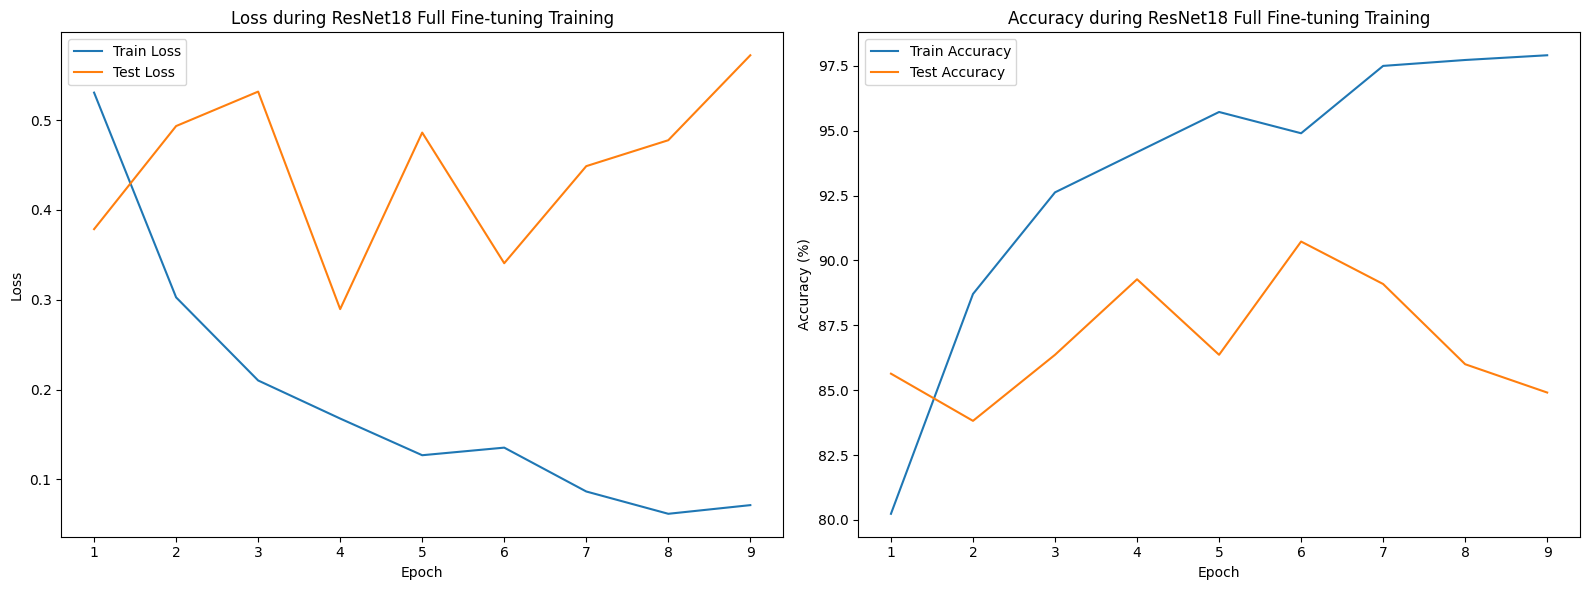

In [ ]:
plot_training_history(train_loss_hist1, train_acc_hist1, test_loss_hist1, test_acc_hist1, title='ResNet18 Full Fine-tuning Training')

# 모델 2(Partial Fine-Tuning + Feature Extraction)




In [ ]:
# 이미지 전처리 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 데이터셋 로드
dataset = ImageFolder(root=data_dir, transform=transform)

images = []
labels = []

for img, label in dataset:
    images.append(img)
    labels.append(label)

images = torch.stack(images)
labels = torch.tensor(labels)

X_train, X_test, y_train, y_test = train_test_split(images.numpy(), labels.numpy(), test_size=0.2, stratify=labels.numpy(), random_state=42)

train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# 모델 설정: ResNet18
model2 = models.resnet18(pretrained=True)

# 마지막 Fully Connected layer 수정 (꽃 클래스 수에 맞게)
num_ftrs = model2.fc.in_features
model2.fc = nn.Linear(num_ftrs, len(dataset.classes))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = model2.to(device)

# 특징 추출기 층 고정
for param in model2.parameters():
    param.requires_grad = False

# 마지막 두 레이어 블록은 학습 가능하게 설정
for name, param in model2.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.0005)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
train_loss_hist2, train_acc_hist2, test_loss_hist2, test_acc_hist2, best_acc2 = train_and_evaluate(
    model=model2, # 실제 모델 객체
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    criterion=criterion,
    optimizer=optimizer, # 실제 optimizer 객체
    session_id=2
)

[Session 2] Epoch [1/30], Train Loss: 0.4293, Train Accuracy: 84.84%, Test Loss: 0.2885, Test Accuracy: 90.55%
[Session 2] Epoch [2/30], Train Loss: 0.1481, Train Accuracy: 95.22%, Test Loss: 0.2922, Test Accuracy: 91.09%
[Session 2] Epoch [3/30], Train Loss: 0.0847, Train Accuracy: 97.04%, Test Loss: 0.3683, Test Accuracy: 90.55%
[Session 2] Epoch [4/30], Train Loss: 0.0490, Train Accuracy: 98.72%, Test Loss: 0.3735, Test Accuracy: 90.00%
[Session 2] Epoch [5/30], Train Loss: 0.0757, Train Accuracy: 97.36%, Test Loss: 0.2824, Test Accuracy: 91.82%
[Session 2] Epoch [6/30], Train Loss: 0.0290, Train Accuracy: 99.00%, Test Loss: 0.2653, Test Accuracy: 92.73%
[Session 2] Epoch [7/30], Train Loss: 0.0432, Train Accuracy: 98.72%, Test Loss: 0.2580, Test Accuracy: 93.45%
[Session 2] Epoch [8/30], Train Loss: 0.0180, Train Accuracy: 99.41%, Test Loss: 0.2335, Test Accuracy: 93.09%
[Session 2] Epoch [9/30], Train Loss: 0.0127, Train Accuracy: 99.64%, Test Loss: 0.2301, Test Accuracy: 93.09%
[

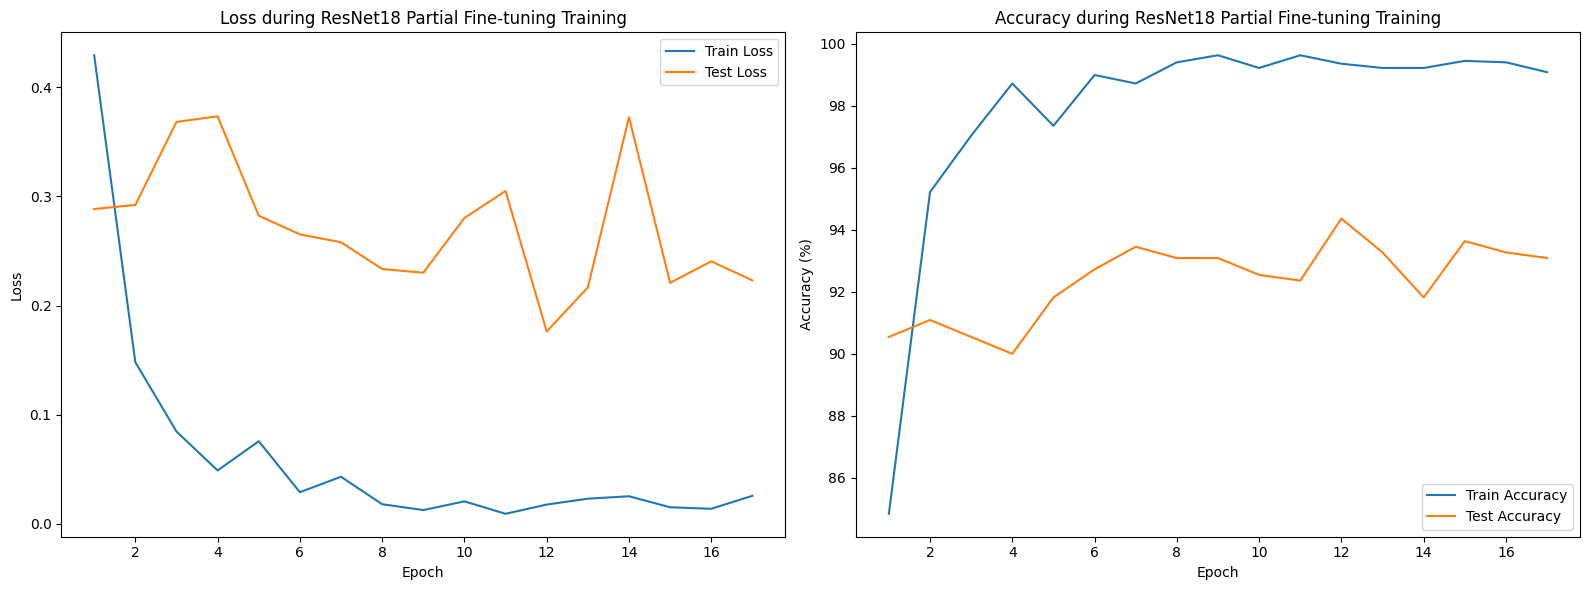

In [ ]:
plot_training_history(train_loss_hist2, train_acc_hist2, test_loss_hist2, test_acc_hist2, title='ResNet18 Partial Fine-tuning Training')

# 모델 3 (Partial Fine-Tuning + Feature Extraction + Regularization)

In [ ]:
# 개선된 이미지 전처리 정의 - 데이터 증강(Data Augmentation) 추가
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # 더 큰 크기로 리사이즈
    transforms.RandomCrop(224),     # 랜덤 크롭 적용
    transforms.RandomHorizontalFlip(p=0.5),  # 50% 확률로 좌우 반전
    transforms.RandomRotation(15),  # 랜덤 회전
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # 색상 변화 추가
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 테스트 데이터에는 데이터 증강 없이 일관된 전처리만 적용
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(root=data_dir, transform=test_transform)

images = []
labels = []

for img, label in dataset:
    images.append(img)
    labels.append(label)

images = torch.stack(images)
labels = torch.tensor(labels)

X_train, X_test, y_train, y_test = train_test_split(
    images.numpy(), labels.numpy(), test_size=0.2,
    stratify=labels.numpy(), random_state=42
)

# 트레이닝 데이터에 대해서는 데이터 증강을 적용하기 위한 커스텀 데이터셋
class AugmentedDataset(Dataset):
    def __init__(self, images, labels, transform):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx].transpose(1, 2, 0)  # C,H,W -> H,W,C

        img = (img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
        img = np.clip(img, 0, 1)
        img = Image.fromarray((img * 255).astype(np.uint8))

        # 데이터 증강 적용
        augmented_img = self.transform(img)
        return augmented_img, self.labels[idx]

train_dataset = AugmentedDataset(X_train, y_train, train_transform)
test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
model3 = models.resnet18(pretrained=True)

# 특징 추출기 층 고정
for param in model3.parameters():
    param.requires_grad = False

# 마지막 두 레이어 블록은 학습 가능하게 설정
for name, param in model3.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True

# 드롭아웃 추가한 새로운 분류기 생성
num_ftrs = model3.fc.in_features
model3.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, len(dataset.classes)) # apply np.unique to the array
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3 = model3.to(device)

criterion = nn.CrossEntropyLoss()

# 옵티마이저 - 학습률 감소 및 가중치 감쇠 적용
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model3.parameters()),
                      lr=0.0005,  # 낮은 학습률 사용
                      weight_decay=0.0001)  # L2 정규화 추가

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
train_loss_hist3, train_acc_hist3, test_loss_hist3, test_acc_hist3, best_acc3 = train_and_evaluate(
    model=model3, # 실제 모델 객체
    train_dataloader=train_dataloader, # 증강된 데이터로더
    test_dataloader=test_dataloader,
    criterion=criterion,
    optimizer=optimizer, # 실제 optimizer 객체
    session_id=3
)

[Session 3] Epoch [1/30], Train Loss: 0.5389, Train Accuracy: 80.37%, Test Loss: 0.2360, Test Accuracy: 92.18%
[Session 3] Epoch [2/30], Train Loss: 0.3105, Train Accuracy: 89.34%, Test Loss: 0.2292, Test Accuracy: 90.91%
[Session 3] Epoch [3/30], Train Loss: 0.2039, Train Accuracy: 93.08%, Test Loss: 0.2228, Test Accuracy: 92.00%
[Session 3] Epoch [4/30], Train Loss: 0.2012, Train Accuracy: 92.71%, Test Loss: 0.1688, Test Accuracy: 94.00%
[Session 3] Epoch [5/30], Train Loss: 0.1460, Train Accuracy: 94.81%, Test Loss: 0.3180, Test Accuracy: 91.45%
[Session 3] Epoch [6/30], Train Loss: 0.1306, Train Accuracy: 95.58%, Test Loss: 0.2073, Test Accuracy: 93.45%
[Session 3] Epoch [7/30], Train Loss: 0.1222, Train Accuracy: 95.77%, Test Loss: 0.1839, Test Accuracy: 94.55%
[Session 3] Epoch [8/30], Train Loss: 0.1138, Train Accuracy: 95.95%, Test Loss: 0.1848, Test Accuracy: 93.45%
[Session 3] Epoch [9/30], Train Loss: 0.0973, Train Accuracy: 96.45%, Test Loss: 0.1752, Test Accuracy: 94.73%
E

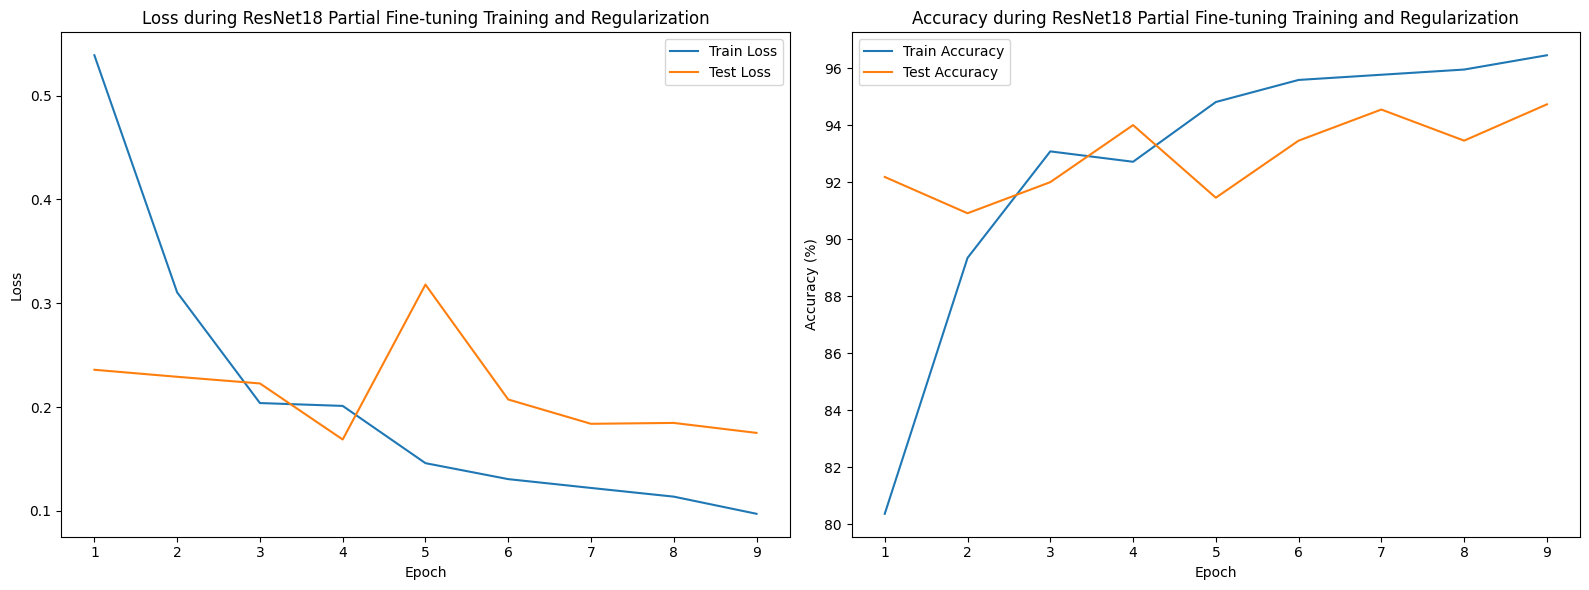

In [ ]:
plot_training_history(train_loss_hist3, train_acc_hist3, test_loss_hist3, test_acc_hist3, title='ResNet18 Partial Fine-tuning Training and Regularization')

# 모델 4 (SimpleCNN + Regularization)

In [ ]:
class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(128 * 28 * 28, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, len(dataset.classes))

  def forward(self, x):
    x = torch.relu(self.conv1(x))
    x = self.pool(x)
    x = torch.relu(self.conv2(x))
    x = self.pool(x)
    x = torch.relu(self.conv3(x))
    x = self.pool(x)
    x = self.flatten(x)
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = self.fc3(x)

    return x

my_model = SimpleCNN()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
my_model = my_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, my_model.parameters()),
                      lr=0.0005,
                      weight_decay=0.0001)

In [ ]:
train_loss_hist4, train_acc_hist4, test_loss_hist4, test_acc_hist4, best_acc4 = train_and_evaluate(
    model=my_model, # 실제 모델 객체
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    criterion=criterion,
    optimizer=optimizer, # 실제 optimizer 객체
    session_id=4
)

[Session 4] Epoch [1/30], Train Loss: 1.2981, Train Accuracy: 44.17%, Test Loss: 1.0933, Test Accuracy: 53.27%
[Session 4] Epoch [2/30], Train Loss: 1.0591, Train Accuracy: 58.20%, Test Loss: 1.0486, Test Accuracy: 57.64%
[Session 4] Epoch [3/30], Train Loss: 0.9751, Train Accuracy: 60.43%, Test Loss: 0.9511, Test Accuracy: 61.09%
[Session 4] Epoch [4/30], Train Loss: 0.9013, Train Accuracy: 64.03%, Test Loss: 0.8962, Test Accuracy: 65.09%
[Session 4] Epoch [5/30], Train Loss: 0.8303, Train Accuracy: 66.94%, Test Loss: 0.8598, Test Accuracy: 67.82%
[Session 4] Epoch [6/30], Train Loss: 0.7742, Train Accuracy: 69.99%, Test Loss: 0.8757, Test Accuracy: 65.64%
[Session 4] Epoch [7/30], Train Loss: 0.7419, Train Accuracy: 71.77%, Test Loss: 0.7843, Test Accuracy: 70.91%
[Session 4] Epoch [8/30], Train Loss: 0.7424, Train Accuracy: 71.27%, Test Loss: 0.7766, Test Accuracy: 70.91%
[Session 4] Epoch [9/30], Train Loss: 0.6996, Train Accuracy: 73.77%, Test Loss: 0.7326, Test Accuracy: 72.18%
[

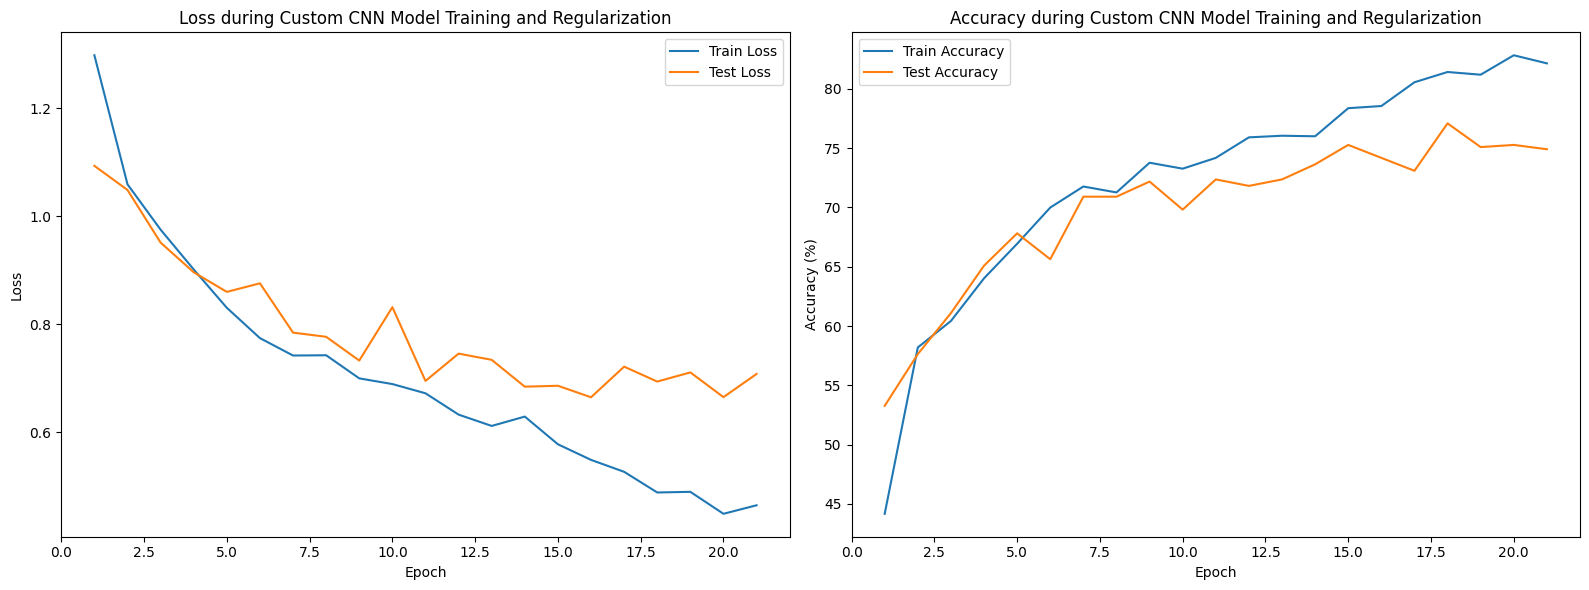

In [ ]:
plot_training_history(train_loss_hist4, train_acc_hist4, test_loss_hist4, test_acc_hist4, title='Custom CNN Model Training and Regularization')

# DB 출력

In [ ]:
def print_training_log(session_id=None):
    """
    training_log 테이블을 조회하고,
    컬럼명과 함께 깔끔하게 출력하는 함수.
    session_id를 지정하면 해당 세션만,
    지정하지 않으면 모든 세션 데이터를 출력.
    """
    # 1) 테이블 정보에서 컬럼명 가져오기
    cursor.execute("PRAGMA table_info(training_log)")
    columns_info = cursor.fetchall()  # [(0, 'id', 'INTEGER', 0, None, 1), ...]
    col_names = [col[1] for col in columns_info]  # ['id', 'session_id', 'epoch', ...]

    # 2) 쿼리 구성
    if session_id is not None:
        query = "SELECT * FROM training_log WHERE session_id = ?"
        cursor.execute(query, (session_id,))
    else:
        query = "SELECT * FROM training_log"
        cursor.execute(query)

    rows = cursor.fetchall()

    # 3) 컬럼명 출력
    print(" | ".join(col_names))
    print("-" * 80)

    # 4) 각 행 출력
    for row in rows:
        row_str = " | ".join(str(item) for item in row)
        print(row_str)

In [ ]:
for log_num in range(1, 5):
  print(f"\n----- 모델{log_num} 데이터 -----")
  print_training_log(session_id=log_num)


----- 모델1 데이터 -----
id | session_id | epoch | start_time | end_time | train_loss | train_accuracy | test_loss | test_accuracy
--------------------------------------------------------------------------------
1 | 1 | 1 | 2025-03-27 05:46:41 | 2025-03-27 05:46:43 | 0.5304849216903466 | 80.2367941712204 | 0.37856152488125694 | 85.63636363636364
2 | 1 | 2 | 2025-03-27 05:46:43 | 2025-03-27 05:46:44 | 0.3026422025716823 | 88.70673952641165 | 0.4932865757081244 | 83.81818181818181
3 | 1 | 3 | 2025-03-27 05:46:44 | 2025-03-27 05:46:46 | 0.21018471886012433 | 92.62295081967213 | 0.5316104532943832 | 86.36363636363636
4 | 1 | 4 | 2025-03-27 05:46:46 | 2025-03-27 05:46:48 | 0.16780447112261385 | 94.1712204007286 | 0.2895893377976285 | 89.27272727272727
5 | 1 | 5 | 2025-03-27 05:46:48 | 2025-03-27 05:46:49 | 0.12701078373398902 | 95.71948998178506 | 0.48602556933959323 | 86.36363636363636
6 | 1 | 6 | 2025-03-27 05:46:49 | 2025-03-27 05:46:51 | 0.13545816253357823 | 94.89981785063752 | 0.340655488

In [ ]:
#판다스 데이터프레임으로 출력

%matplotlib inline

# 기존에 사용 중이던 DB 연결
conn = sqlite3.connect('training_logs.db')

# training_log 테이블 전체 데이터를 판다스 DataFrame으로 불러오기
df = pd.read_sql_query("SELECT * FROM training_log", conn)

# DB 연결 종료(더 이상 쿼리할 일이 없다면)
conn.close()

In [ ]:
df[df['session_id']==1]

,id,session_id,epoch,start_time,end_time,train_loss,train_accuracy,test_loss,test_accuracy
0,1,1,1,2025-03-27 05:46:41,2025-03-27 05:46:43,0.530485,80.236794,0.378562,85.636364
1,2,1,2,2025-03-27 05:46:43,2025-03-27 05:46:44,0.302642,88.706740,0.493287,83.818182
2,3,1,3,2025-03-27 05:46:44,2025-03-27 05:46:46,0.210185,92.622951,0.531610,86.363636
3,4,1,4,2025-03-27 05:46:46,2025-03-27 05:46:48,0.167804,94.171220,0.289589,89.272727
4,5,1,5,2025-03-27 05:46:48,2025-03-27 05:46:49,0.127011,95.719490,0.486026,86.363636
5,6,1,6,2025-03-27 05:46:49,2025-03-27 05:46:51,0.135458,94.899818,0.340655,90.727273
6,7,1,7,2025-03-27 05:46:51,2025-03-27 05:46:52,0.086661,97.495446,0.448669,89.090909
7,8,1,8,2025-03-27 05:46:52,2025-03-27 05:46:54,0.061837,97.723133,0.477524,86.000000
8,9,1,9,2025-03-27 05:46:54,2025-03-27 05:46:56,0.071477,97.905282,0.572059,84.909091


In [ ]:
df[df['session_id']==2]

,id,session_id,epoch,start_time,end_time,train_loss,train_accuracy,test_loss,test_accuracy
9,10,2,1,2025-03-27 05:47:06,2025-03-27 05:47:07,0.429349,84.836066,0.288474,90.545455
10,11,2,2,2025-03-27 05:47:07,2025-03-27 05:47:08,0.148125,95.218579,0.292184,91.090909
11,12,2,3,2025-03-27 05:47:08,2025-03-27 05:47:09,0.084694,97.040073,0.368267,90.545455
12,13,2,4,2025-03-27 05:47:09,2025-03-27 05:47:10,0.048962,98.724954,0.373451,90.000000
13,14,2,5,2025-03-27 05:47:10,2025-03-27 05:47:11,0.075715,97.358834,0.282353,91.818182
14,15,2,6,2025-03-27 05:47:11,2025-03-27 05:47:12,0.029047,98.998179,0.265254,92.727273
15,16,2,7,2025-03-27 05:47:12,2025-03-27 05:47:13,0.043196,98.724954,0.258013,93.454545
16,17,2,8,2025-03-27 05:47:13,2025-03-27 05:47:14,0.018048,99.408015,0.233529,93.090909
17,18,2,9,2025-03-27 05:47:14,2025-03-27 05:47:15,0.012679,99.635701,0.230129,93.090909
18,19,2,10,2025-03-27 05:47:15,2025-03-27 05:47:16,0.020649,99.225865,0.280259,92.545455


In [ ]:
df[df['session_id']==3]

,id,session_id,epoch,start_time,end_time,train_loss,train_accuracy,test_loss,test_accuracy
26,27,3,1,2025-03-27 05:47:34,2025-03-27 05:47:46,0.538864,80.373406,0.235967,92.181818
27,28,3,2,2025-03-27 05:47:46,2025-03-27 05:47:58,0.310470,89.344262,0.229194,90.909091
28,29,3,3,2025-03-27 05:47:58,2025-03-27 05:48:10,0.203908,93.078324,0.222792,92.000000
29,30,3,4,2025-03-27 05:48:10,2025-03-27 05:48:22,0.201158,92.714026,0.168804,94.000000
30,31,3,5,2025-03-27 05:48:22,2025-03-27 05:48:33,0.146020,94.808743,0.318026,91.454545
31,32,3,6,2025-03-27 05:48:34,2025-03-27 05:48:45,0.130641,95.582878,0.207343,93.454545
32,33,3,7,2025-03-27 05:48:45,2025-03-27 05:48:58,0.122152,95.765027,0.183929,94.545455
33,34,3,8,2025-03-27 05:48:58,2025-03-27 05:49:10,0.113775,95.947177,0.184776,93.454545
34,35,3,9,2025-03-27 05:49:10,2025-03-27 05:49:21,0.097252,96.448087,0.175177,94.727273


In [ ]:
df[df['session_id']==4]

,id,session_id,epoch,start_time,end_time,train_loss,train_accuracy,test_loss,test_accuracy
35,36,4,1,2025-03-27 05:49:22,2025-03-27 05:49:34,1.298130,44.171220,1.093278,53.272727
36,37,4,2,2025-03-27 05:49:34,2025-03-27 05:49:47,1.059059,58.196721,1.048599,57.636364
37,38,4,3,2025-03-27 05:49:47,2025-03-27 05:49:59,0.975070,60.428051,0.951095,61.090909
38,39,4,4,2025-03-27 05:49:59,2025-03-27 05:50:12,0.901315,64.025501,0.896162,65.090909
39,40,4,5,2025-03-27 05:50:12,2025-03-27 05:50:24,0.830329,66.939891,0.859810,67.818182
40,41,4,6,2025-03-27 05:50:24,2025-03-27 05:50:36,0.774178,69.990893,0.875675,65.636364
41,42,4,7,2025-03-27 05:50:36,2025-03-27 05:50:49,0.741923,71.766849,0.784346,70.909091
42,43,4,8,2025-03-27 05:50:49,2025-03-27 05:51:01,0.742419,71.265938,0.776611,70.909091
43,44,4,9,2025-03-27 05:51:01,2025-03-27 05:51:13,0.699583,73.770492,0.732610,72.181818
44,45,4,10,2025-03-27 05:51:13,2025-03-27 05:51:26,0.689072,73.269581,0.831520,69.818182
